# Empirical Variography

<!-- SUMMARY: This script is part of the course designed for ERAMET. It presents the Variography. -->

<!-- CATEGORY: Courses -->

In this notebook, we will study how to perform the variography of a single variable.

We will discover:
* the variogram cloud
* the omnidirectional variogram
* the variogram map
* the directional variogram

In [1]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.widgets as gw
import gstlearn.document as gdoc
import ipywidgets as widgets
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
from IPython.display import Markdown

%matplotlib inline
%matplotlib notebook

gdoc.setNoScroll()
figsize=[6,6]
gp.setDefault(dims=figsize)

<IPython.core.display.Javascript object>

## Read the db

Here we restore the db which as been created in the first [notebook](FirstSteps.ipynb).

In [2]:
temp_nf = gdoc.loadData("Scotland", "Scotland_Temperatures.NF")
db = gl.Db.createFromNF(temp_nf)
db


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 236

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = Longitude - Locator = x1
Column = 2 - Name = Latitude - Locator = x2
Column = 3 - Name = Elevation - Locator = NA
Column = 4 - Name = January_temp - Locator = z1

## Some functions and constant values

- Reference parameters

In [3]:
nlag_ref = 10  # Total number of lags
lag_ref = 70 # Value for the lag
tol_ref = 50 # Tolerane on distance (in percentage of the lag)
angle_ref = 125
tolangle_ref = 20
lagindex_ref = 4 # Index of a particular lag
cylrad_ref = 50 # Extension of the radius of the cylinder search

- Global parameters

In [4]:
nlag = nlag_ref
lag = lag_ref
tol = tol_ref
lagindex = lagindex_ref
angle = angle_ref
tolangle = tolangle_ref
cylrad = cylrad_ref

flagCloud = True
flagOneLag = True
flagValues = False
flagLimitVariance = False
flagDirectional = False
flagCylinder = False

caseFigure = 1

- Calculation functions

In [5]:
def getSelectedPairs(varioparam,db,lagindex):
    selected = gl.buildDbFromVarioParam(db,varioparam)
    ind = np.where(selected["Lag"]==lagindex)
    s1 = selected["Sample-1"][ind]
    s2 = selected["Sample-2"][ind]
    vect = db.getIncrements(s1, s2)
    return vect[0],vect[1]

# Function to average within ]mini,maxi]
def average(dist,gamma,mini,maxi) :
    ind = np.logical_and(dist>mini,dist<=maxi)  #Check if the distances are in ]mini,maxi]
    if sum(ind) > 0:
        hh = np.mean(dist[ind]) #Compute the means of distance for pairs in ]mini,maxi]
        gg = np.mean(gamma[ind]) #Compute the means of gamma for pairs in ]mini,maxi]
        nbpairs = np.sum(ind)/2 # Count the number of pairs between ]mini,maxi]
    else:
        hh = np.nan
        gg = np.nan
        nbpairs = 0
    return nbpairs,hh,gg

def omnivario(nlag,lag,tol):
    HH = []
    GG = []
    NB = []

    #Loop over the lag 
    for i in range(nlag):

        # Compute the minimum and maximum distances for the lag i
        mini, center, maxi = gp.lagDefine(i, lag, tol)
        nbpairs,hh,gg=average(dist,gamma,mini, maxi)
    
        #Storage
        HH+=[hh]
        GG+=[gg]
        NB+=[nbpairs]
    
    return HH,GG,NB

- Event functions (triggered by the widgets) as well as functions for resetting the global parameters to their default values.

In [6]:
def sliderLagIndexEventhandler(change):
    global lagindex
    lagindex = change.new
    drawFigure(ax)
    
def sliderLagEventhandler(change):
    global lag
    lag = change.new
    drawFigure(ax)
    
def sliderTolEventhandler(change):
    global tol
    tol = change.new
    drawFigure(ax)
    
def sliderAngleEventhandler(change):
    global angle
    angle = change.new
    drawFigure(ax)
    
def sliderTolAngleEventhandler(change):
    global tolangle
    tolangle = change.new
    drawFigure(ax)
    
def sliderCylinderEventhandler(change):
    global cylrad
    cylrad = change.new
    drawFigure(ax)
    
def reset1D(flagCloud_arg, flagOneLag_arg, flagValues_arg, flagLimitVariance_arg):
    global nlag, lag, tol, lagindex
    nlag = nlag_ref
    lag = lag_ref
    tol = tol_ref
    lagindex = lagindex_ref
    
    global flagCloud, flagOneLag, flagValues, flagLimitVariance
    flagCloud = flagCloud_arg
    flagOneLag = flagOneLag_arg
    flagValues = flagValues_arg
    flagLimitVariance = flagLimitVariance_arg
    
    global caseFigure
    caseFigure = 1
    
def reset2D(flagOneLag_arg=True, flagDirectional_arg=False, flagCylinder_arg=False):
    global nlag, lag, tol, lagindex, angle, tolangle, cylrad
    nlag = nlag_ref
    lag = lag_ref
    tol = tol_ref
    lagindex = lagindex_ref
    angle = angle_ref
    tolangle = tolangle_ref
    cylrad = cylrad_ref
    
    global flagOneLag, flagDirectional, flagCylinder
    flagOneLag = flagOneLag_arg
    flagDirectional = flagDirectional_arg
    flagCylinder = flagCylinder_arg
    
    global caseFigure
    caseFigure = 2

- Graphical functions

In [7]:
# Draw one lag (lower, upper and center locations)
def drawOneLag(ax, i, lag, tol=0):
    mini, center, maxi = gp.lagDefine(i, lag, tol)
    
    ax.axvline(x = center, ymin = 0.,c="red")
    if tol>0:
        if i>0:
            ax.axvline(x = mini, ymin = 0.,c="green")
        ax.axvline(x = maxi, ymin = 0.,c="green")
        
# Draw the variogram cloud
def drawCloud(ax, dist, gamma, s=1, flagHist = False):
    if flagHist:
        ax.hist2d(dist,gamma,bins=50)
    else:
        ax.scatter(dist, gamma, s)
    
# Draw all lag centers (in black)
def drawAllLagCenters(ax, nlag=nlag_ref, lag=lag_ref):
    for i in range(nlag):
        mini, center, maxi = gp.lagDefine(i, lag, 0.)
        ax.axvline(x = center, ymin = 0.,c="black")
            
# Draw the variance (dashed line)
def drawVariance(ax):
    ax.axhline(y = variance, color = 'black', linestyle = 'dashed')
    
# Draw the average value for one lag
def drawAverage(ax, i, lag=lag_ref, tol=tol_ref):
    mini, center, maxi = gp.lagDefine(i, lag, tol)
    nbpairs,hh,gg=average(dist,gamma,mini, maxi)
    ax.scatter(hh,gg)
    ax.text(hh,gg,int(nbpairs))

def drawGrid(vmap,ax):
    mx = np.min(vmap["x1"])-vmap.getDX(0)/2
    Mx = np.max(vmap["x1"])+vmap.getDX(0)/2
    my = np.min(vmap["x2"])-vmap.getDX(1)/2
    My = np.max(vmap["x2"])+vmap.getDX(1)/2

    for i in range(vmap.getNX(0)+1):
        x = vmap.getX0(0)+(i-0.5) * vmap.getDX(0)
        ax.plot([x,x],[my,My], color = 'black',linewidth=0.5)
    for i in range(vmap.getNX(1)+1):
        y = vmap.getX0(1)+(i-0.5) * vmap.getDX(1)
        ax.plot([mx,Mx],[y,y], color = 'black',linewidth=0.5)
        
def drawFigure1D(ax):
    ax.cla()
    
    if flagCloud:
        drawCloud(ax, dist, gamma)
    if flagOneLag:
        if flagValues:
            drawAverage(ax, lagindex, lag, tol)
            drawOneLag(ax, lagindex, lag, tol)
        else:
            drawAllLagCenters(ax, nlag, lag)
            drawOneLag(ax, lagindex, lag, tol)
    else:
        HH,GG,NB = omnivario(nlag,lag,tol)
        for i in range(nlag):
            plt.scatter(HH[i],GG[i],c="black")
            plt.text(HH[i],GG[i],int(NB[i]))
        plt.plot(HH,GG, '--')
    
    drawVariance(ax)
    
    if flagLimitVariance:
        plt.ylim([0,variance * 2])
        
    plt.gca().set_adjustable("box")
    plt.gca().set_xlim(left=0)
    plt.gca().set_ylim(bottom=0)
        
def drawFigure2D(ax):
    ax.cla()

    if flagDirectional:
        if flagCylinder:
            direction = gl.DirParam.create(nlag,lag,tol,tolangle,angle2D = angle, cylrad=cylrad)
        else:
            direction = gl.DirParam.create(nlag,lag,tol,tolangle,angle2D = angle)
        varioParam = gl.VarioParam()
        varioParam.addDir(direction)
    else:
        varioParam = gl.VarioParam.createOmniDirection(nlag,lag,tol)

    plt.scatter(deltaX,deltaY,s=.08,c='blue',label="Unselected pairs")
    plt.scatter(0,0)
    xs,ys = getSelectedPairs(varioParam,db,lagindex)
    plt.scatter(xs,ys,s=.08,label="Selected pairs",c='yellow')

    if flagOneLag:
        mini, center, maxi = gp.lagDefine(lagindex, lag, tol)
        gp.drawCircles(mini, maxi,True)
    else:
        for i in range(nlag):
            mini, center, maxi = gp.lagDefine(i, lag, tol)
            xs,ys = getSelectedPairs(varioParam,db,i)
            plt.scatter(xs,ys,s=.08,label="Selected pairs",c='yellow')
            gp.drawCircles(mini, maxi)

    if flagDirectional:
        gp.drawDir(angle,         "black")
        gp.drawDir(angle+tolangle,"red")
        gp.drawDir(angle-tolangle,"red")

    if flagCylinder:
        gp.drawCylrad(angle,cylrad,col="purple")
    
    plt.axis("equal")
    plt.gca().set_adjustable("box")
    plt.gca().set_xlim(left=-500, right=500)
    plt.gca().set_ylim(bottom=-500, top=500)

def drawFigure(ax):
    if caseFigure == 1:
        drawFigure1D(ax)
    else:
        drawFigure2D(ax)

## Omnidirectional 

### Variogram cloud

In [8]:
Markdown(gdoc.loadDoc("Variogram_Cloud.md"))

<style>md-block { color:gray; background-color:white; }</style><md-block>
**Variogram Cloud**

The data is modeled as *samples of a regionalized* variable $z$, i.e. as evaluations at locations $x_1,..,x_n$ of a variable $z$ defined across a spatial domain: 
$$\lbrace z_i = z(x_i) : i = 1, ..., n\rbrace.$$

The variogram cloud is the set of pair of points defined as
$$ \big\lbrace \big( \Vert x_i - x_j\Vert,  \big\vert z(x_i)-z(x_j)\big\vert^2 \big) \quad\text{where}\quad 1\le i\le j\le n \big\rbrace $$

In **gstlearn**, variogram clouds are computed as grids.
</md-block>

Compute the exhaustive variogram cloud

In [9]:
# Retrieve Coordinates and Variable from db
zp = db["*temp"]
    
# Reduce to defined samples
ind = np.argwhere(np.invert(np.isnan(zp)))
ztab = np.atleast_2d(zp[ind].reshape(-1,))

#Matrix of coordinates
xtab = db["Longitude"][ind].reshape(-1,)
ytab = db["Latitude"][ind].reshape(-1,)
coords = np.array([xtab,ytab]).T

# Matrix of distance flattened in a vector
dist = distance_matrix(coords,coords).reshape(-1,) 

#Matrix of gamma_{ij} flattened in a vector 
gamma = 0.5 * (ztab-ztab.T).reshape(-1,)**2

variance = np.var(ztab)

The next figure represents the data set (restricted to the only samples where the target variable is defined)

<IPython.core.display.Javascript object>


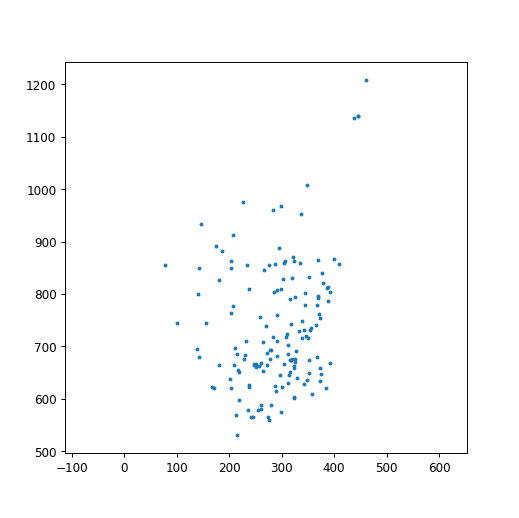

(59.075, 479.825, 496.47499999999997, 1242.825)

In [10]:
fig,ax=plt.subplots(1,1,figsize=figsize)
ax.scatter(xtab,ytab,s=5)
ax.axis("equal")

Plot the variogram cloud together with the experimental variance (dashed horizontal line)

<IPython.core.display.Javascript object>


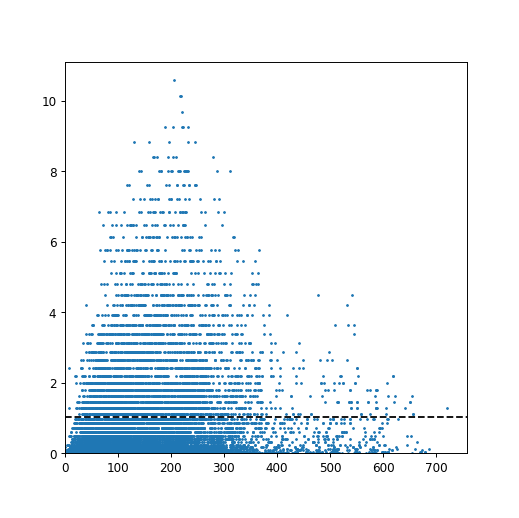

(0.0, 11.109000000000002)

In [11]:
fig, ax = plt.subplots(1,1,figsize=figsize)
drawCloud(ax, dist, gamma)
drawVariance(ax)
ax.set_adjustable("box")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

In order to have a more visible scatter plot, the plot is subdivided into small cells and the numbers of pairs falling in each cell are displayed. The vertical scale has been reduced voluntarily as the number of pairs tends to be very small for large variability values. 

<IPython.core.display.Javascript object>


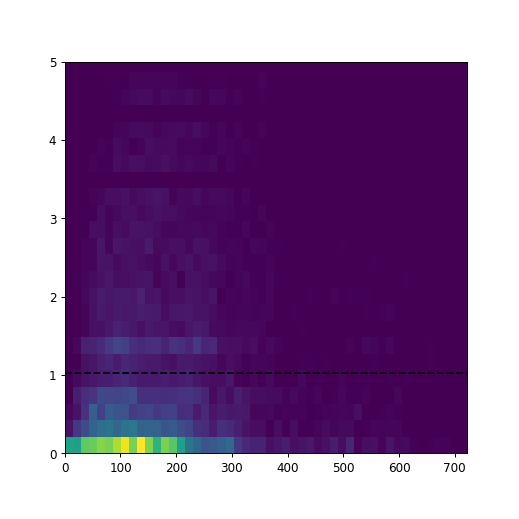

(0.0, 5.0)

In [12]:
fig, ax = plt.subplots(1,1,figsize=figsize)
drawCloud(ax, dist, gamma, flagHist=True)
drawVariance(ax)
ax.set_adjustable("box")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=5)

### Empirical variogram

Split the variogram cloud into several lags

<IPython.core.display.Javascript object>


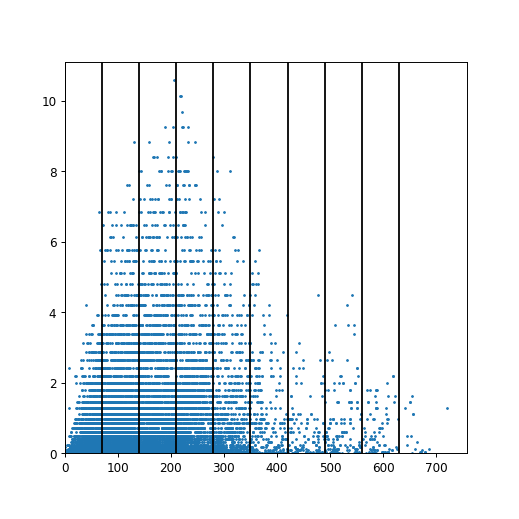

(0.0, 11.109000000000002)

In [13]:
fig, ax = plt.subplots(1,1,figsize=figsize)
drawCloud(ax, dist, gamma)
drawAllLagCenters(ax)
ax.set_adjustable("box")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

In the following paragraph, you can play with the lag index, the lag size and the tolerance parameter

IntSlider(value=4, continuous_update=False, description='Lag Index', max=10)

<IPython.core.display.Javascript object>


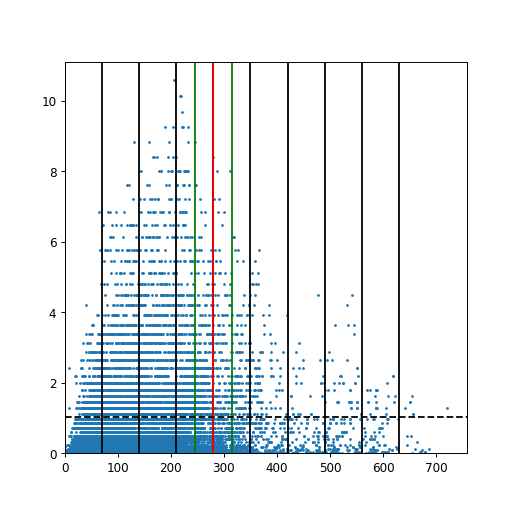

In [14]:
widgetLagIndex = gw.sliderInt(title='Lag Index',
                              value=lagindex_ref, mini=0, maxi=nlag_ref,
                              eventhandler=sliderLagIndexEventhandler)
widgetLag      = gw.sliderFloat(title='Lag Size',
                               value = lag_ref, mini=5, maxi=200,
                               eventhandler=sliderLagEventhandler)
widgetTol      = gw.sliderFloat(title='Tolerance',
                               value = tol_ref, mini=0, maxi=99,
                               eventhandler=sliderTolEventhandler)

widgetLagAndTol = widgets.HBox([ widgetLag, widgetTol])

display(widgetLagAndTol)
display(widgetLagIndex)

reset1D(flagCloud_arg=True, flagOneLag_arg=True, flagValues_arg=False, flagLimitVariance_arg=False)
fig, ax = plt.subplots(1,1,figsize=figsize)
drawFigure(ax)

Note that with a tolerance of 50\%, all the pairs (below the user maximum distance) are selected exactly once.

### Average per lag

For each lag, we average all the values between the two bounds (average of distances 
$d_{ij}$, average of $\gamma_{ij}$) and we count the number of selected pairs.



IntSlider(value=4, continuous_update=False, description='Lag Index', max=10)

<IPython.core.display.Javascript object>


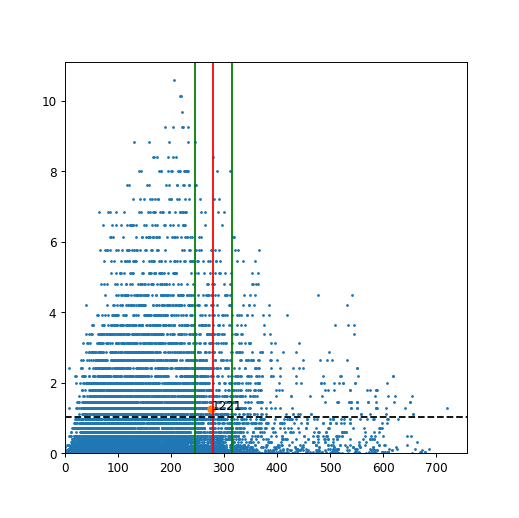

In [15]:
widgetLagIndex = gw.sliderInt(title='Lag Index',
                              value=lagindex_ref, mini=0, maxi=nlag_ref,
                              eventhandler=sliderLagIndexEventhandler)
widgetLag      = gw.sliderFloat(title='Lag Size',
                               value = lag_ref, mini=5, maxi=200,
                               eventhandler=sliderLagEventhandler)
widgetTol     = gw.sliderFloat(title='Tolerance',
                               value = tol_ref, mini=0, maxi=99,
                               eventhandler=sliderTolEventhandler)
widgetLagAndTol = widgets.HBox([ widgetLag, widgetTol])

display(widgetLagAndTol)
display(widgetLagIndex)

reset1D(flagCloud_arg=True, flagOneLag_arg=True, flagValues_arg=True, flagLimitVariance_arg = False)
fig, ax = plt.subplots(1,1,figsize=figsize)
drawFigure(ax)

Loop to calculate the average for all lags

<IPython.core.display.Javascript object>


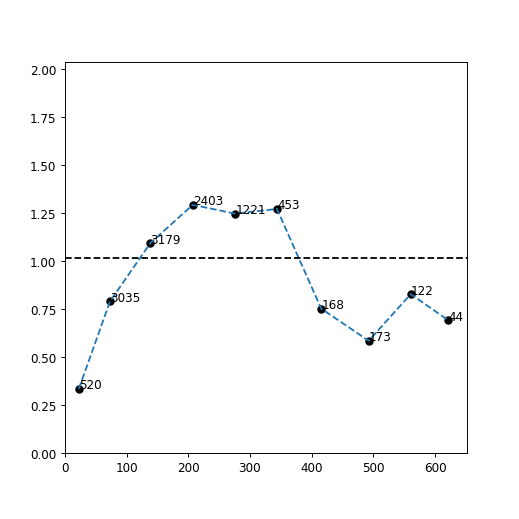

In [16]:
widgetLag     = gw.sliderFloat(title='Lag Size',
                               value = lag_ref, mini=5, maxi=200,
                               eventhandler=sliderLagEventhandler)
widgetTol     = gw.sliderFloat(title='Tolerance',
                               value = tol_ref, mini=0, maxi=99,
                               eventhandler=sliderTolEventhandler)
widgetLagAndTol = widgets.HBox([ widgetLag, widgetTol])

display(widgetLagAndTol)

reset1D(flagCloud_arg=False, flagOneLag_arg=False, flagValues_arg=True, flagLimitVariance_arg = True)
fig, ax = plt.subplots(1,1,figsize=figsize)
drawFigure(ax)

Let's collect the result in a table.

In [17]:
HH,GG,NB = omnivario(nlag_ref,lag_ref,tol_ref)

dd=pd.DataFrame(np.vstack((np.array(NB),np.round(HH,3),np.round(GG,3))).T)
dd.columns = ["Npairs","Distance","Value"]
dd

,Npairs,Distance,Value
0,520.0,22.745,0.336
1,3035.0,73.179,0.791
2,3179.0,138.616,1.095
3,2403.0,207.346,1.294
4,1221.0,276.153,1.248
5,453.0,343.824,1.273
6,168.0,415.494,0.753
7,173.0,492.507,0.586
8,122.0,560.622,0.829
9,44.0,621.180,0.694


## Directional variography

To obtain an empirical variogram (omnidirectional), the computations (selection of pairs) were based on the distance matrix between all the pairs. For directional quantities one have to consider $d$ matrices (where $d$ is the dimension of the space) storing the coordinates of the separating vectors between all the pairs of points. Then the computations (variogram maps, direcional variograms, ...) are based on conditions on these vectors. 

First, we represent the base map and a segment (in red) between to specific points.

<IPython.core.display.Javascript object>


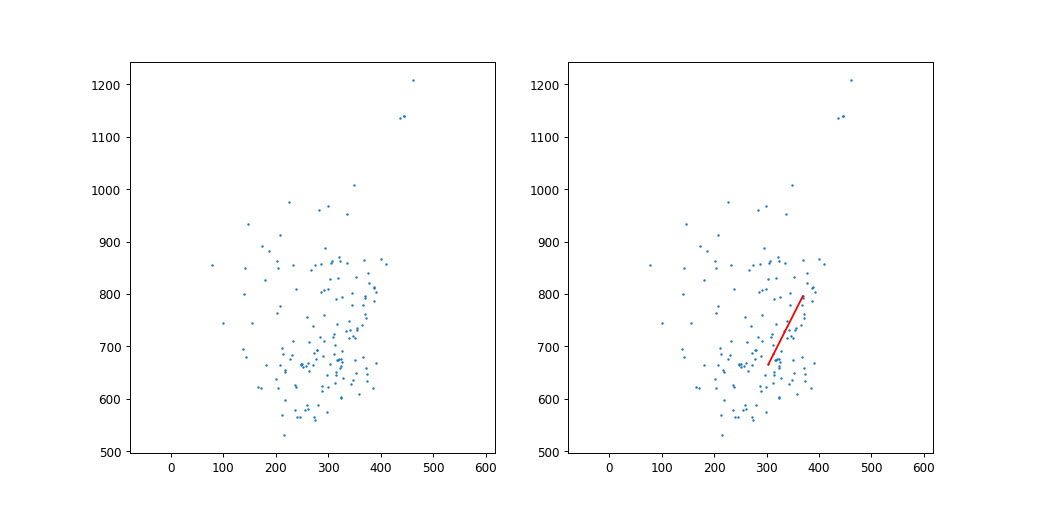

In [18]:
#Get 2 random locations (ranked 1 and 100)
ind = [1,100]

fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(xtab,ytab,s=1)
a = ax[0].axis("equal")

ax[1].scatter(xtab,ytab,s=1)
ax[1].plot(xtab[ind],ytab[ind],c="r")
a = ax[1].axis("equal")

On the next graphic, we represent all the vectors of separation between the locations.

More precisely, on the following figure (left), we put one of the point on the origin and we represent the second point  relatively. We join them by a segment (to keep the idea of vector).

If we inverse the roles of each point we obtain another point and another segment.

Then we repeat the process for all the pairs of points (without drawing the segments). We obtain the right figure.

In [19]:
#Compute vectors
deltaX = np.atleast_2d(xtab)-np.atleast_2d(xtab).T
deltaY = np.atleast_2d(ytab)-np.atleast_2d(ytab).T
dindx  = deltaX[ind[0],:][ind[1]]
dindy  = deltaY[ind[0],:][ind[1]]
deltax = deltaX.reshape(-1,)
deltaY = deltaY.reshape(-1,)

<IPython.core.display.Javascript object>


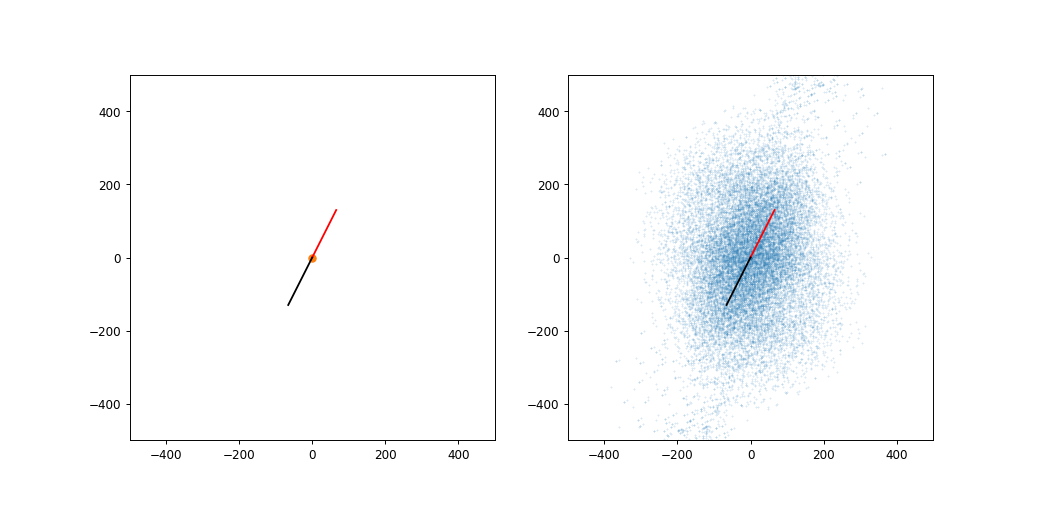

(-500.0, 500.0)

In [20]:
#Display the result
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].scatter(deltaX,deltaY,s=.0)
ax[0].plot([0,dindx],[0,dindy],c="r")
ax[0].plot([0,-dindx],[0,-dindy],c="black")
ax[0].scatter(0,0)
ax[0].axis("equal")
ax[0].set_adjustable("box")
ax[0].set_xlim(left=-500, right=500)
ax[0].set_ylim(bottom=-500, top=500)

ax[1].scatter(deltaX,deltaY,s=.01)
ax[1].plot([0,dindx],[0,dindy],c="r")
ax[1].plot([0,-dindx],[0,-dindy],c="black")
ax[1].axis("equal")
ax[1].set_adjustable("box")
ax[1].set_xlim(left=-500, right=500)
ax[1].set_ylim(bottom=-500, top=500)

### Variogram Map

The variogram map is an exploratory tool which can be useful to detect anisotropies.

Instead of averaging the $d_{ij}$ and the $\gamma_{ij}$ with respect to the distance separating the locations (as in the omni-directional variogram), in the variogram map, it is averaged based on conditions on each coordinates of the separating vectors.

More precisely, we average over cells of a predefined grid as illustrated below. 

Note that it is useful to consider the number of pairs in each cell to assess the quality of the result. 

With **gstlearn**, we just have to specify the input *Db*, the calcul mode (here variogram), and the number of cells of the grid (here [20,20]).

In [21]:
vmap = gl.db_vmap(db,gl.ECalcVario.VARIOGRAM,[20,20])
vmap

AttributeError: module 'gstlearn' has no attribute 'db_vmap'

Now, let's illustrate the process.

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,9))

ax[0][0].scatter(deltaX,deltaY,s=.01)
ax[0][0].scatter(0,0)
ax[0][0].axis("equal")
ax[0][0].set_adjustable("box")
ax[0][0].set_xlim(left=-500, right=500)
ax[0][0].set_ylim(bottom=-500, top=500)

ax[0][1].scatter(deltaX,deltaY,s=.01)
drawGrid(vmap,ax[0][1])
ax[0][1].scatter(0,0)
ax[0][1].axis("equal")
ax[0][1].set_adjustable("box")
ax[0][1].set_xlim(left=-500, right=500)
ax[0][1].set_ylim(bottom=-500, top=500)

ax[1][0].raster(vmap,name="*.Var",flagLegend=True)
drawGrid(vmap,ax[1][0])
ax[1][0].decoration(title='Variogram')
ax[1][0].axis("equal")
ax[1][0].set_adjustable("box")
ax[1][0].set_xlim(left=-500, right=500)
ax[1][0].set_ylim(bottom=-500, top=500)

ax[1][1].raster(vmap,"*.Nb",flagLegend=True)
drawGrid(vmap,ax[1][1])
ax[1][1].decoration(title="Number of pairs")
ax[1][1].axis("equal")
ax[1][1].set_adjustable("box")
ax[1][1].set_xlim(left=-500, right=500)
ax[1][1].set_ylim(bottom=-500, top=500)

plt.show()

### Directional variograms

The variogram map is not really robust as the number of pairs in each cell can be small.

So, we will consider directional variogram which is a more robust tool. The idea is to choose a direction and then to consider (for a given lag distance) all the pairs with direction "close" to this direction.

First, we start to illustrate with the omnidirectional case.

In this case, only the distance between locations is considered to select the pairs at a given lag. 

In [ ]:
widgetLagIndex = gw.sliderInt(title='Lag Index',
                              value=lagindex_ref, mini=0, maxi=nlag_ref,
                              eventhandler=sliderLagIndexEventhandler)

display(widgetLagIndex)

reset2D(flagOneLag_arg=True, flagDirectional_arg=False, flagCylinder_arg=False)
fig, ax = plt.subplots(1,1,figsize=figsize)
drawFigure(ax)

We can also define a direction in particular (defined by its angle) as well as the angular tolerance.

In [ ]:
widgetAngle = gw.sliderInt(title='Angle',
                              value=angle_ref, mini=0, maxi=360,
                              eventhandler=sliderAngleEventhandler)
widgetTolAngle = gw.sliderInt(title='Tol. Angle',
                              value=tolangle_ref, mini=0, maxi=90,
                              eventhandler=sliderTolAngleEventhandler)
widgetLagIndex = gw.sliderInt(title='Lag Index',
                              value=lagindex_ref, mini=0, maxi=nlag_ref,
                              eventhandler=sliderLagIndexEventhandler)
widgetAngleAndTol = widgets.HBox([widgetAngle, widgetTolAngle])

display(widgetAngleAndTol)
display(widgetLagIndex)

reset2D(flagOneLag_arg=True, flagDirectional_arg=True, flagCylinder_arg=False)
fig, ax = plt.subplots(1,1,figsize=figsize)
drawFigure(ax)

We can avoid to be too far from the principal direction by adding a third constraint (cylrad).

In [ ]:
widgetAngle = gw.sliderInt(title='Angle',
                              value=angle_ref, mini=0, maxi=360,
                              eventhandler=sliderAngleEventhandler)
widgetTolAngle = gw.sliderInt(title='Tol. Angle',
                              value=tolangle_ref, mini=0, maxi=90,
                              eventhandler=sliderTolAngleEventhandler)
widgetCylinder = gw.sliderInt(title='Cylinder',
                              value=cylrad_ref, mini=0, maxi=100,
                              eventhandler=sliderCylinderEventhandler)
widgetLagIndex = gw.sliderInt(title='Lag Index',
                              value=lagindex_ref, mini=0, maxi=nlag_ref,
                              eventhandler=sliderLagIndexEventhandler)
widgetAngleAndTolAndCyl = widgets.HBox([widgetAngle, widgetTolAngle, widgetCylinder])

display(widgetAngleAndTolAndCyl)
display(widgetLagIndex)

reset2D(flagOneLag_arg=True, flagDirectional_arg=True, flagCylinder_arg=True)
fig, ax = plt.subplots(1,1,figsize=figsize)
drawFigure(ax)

Then we repeat the process to get the variogram for all lags of a direction.

In [ ]:
widgetAngle = gw.sliderInt(title='Angle',
                              value=angle_ref, mini=0, maxi=360,
                              eventhandler=sliderAngleEventhandler)
widgetTolAngle = gw.sliderInt(title='Tol. Angle',
                              value=tolangle_ref, mini=0, maxi=90,
                              eventhandler=sliderTolAngleEventhandler)
widgetCylinder = gw.sliderInt(title='Cylinder',
                              value=cylrad_ref, mini=0, maxi=100,
                              eventhandler=sliderCylinderEventhandler)
widgetAngleAndTolAndCyl = widgets.HBox([widgetAngle, widgetTolAngle, widgetCylinder])

display(widgetAngleAndTolAndCyl)

reset2D(flagOneLag_arg=False, flagDirectional_arg=True, flagCylinder_arg=True)
fig, ax = plt.subplots(1,1,figsize=figsize)
drawFigure(ax)

Then we can compute the empirical variogram.

In [ ]:
direction1 = gl.DirParam.create(nlag_ref,lag_ref,tol_ref,
                                tolangle_ref,angle2D = angle_ref, cylrad=cylrad_ref)
varioParamDir = gl.VarioParam()
varioParamDir.addDir(direction1)
varioexpDir = gl.Vario.computeFromDb(varioParamDir,db)

fig, ax = plt.subplots(1,1,figsize=figsize)
ax.variogram(varioexpDir, showPairs=True)
ax.decoration(title="Experimental Variogram (first direction)")
plt.show()

Let's compute in another direction (orthogonal to the first one)

In [ ]:
direction2 = gl.DirParam.create(nlag_ref,lag_ref,tol_ref,
                                tolangle_ref,angle2D = angle_ref+90, cylrad=cylrad_ref)
varioParamDir = gl.VarioParam()
varioParamDir.addDir(direction2)
varioexpDir = gl.Vario.computeFromDb(varioParamDir,db)

fig, ax = plt.subplots(1,1,figsize=figsize)
ax.variogram(varioexpDir, showPairs=True)
ax.decoration(title="Experimental Variogram (second direction)")
plt.show()

In [ ]:
# Construct a VarioParm with both directions
varioParamDir = gl.VarioParam()
varioParamDir.addDir(direction1)
varioParamDir.addDir(direction2)

# Compute the experimental variogram with two calculation directions
varioexpDir = gl.Vario.computeFromDb(varioParamDir,db)

# Display the experimental variogram
fig, ax = plt.subplots(1,1,figsize=[8,8])
ax.variogram(varioexpDir, idir=-1, showPairs=True)
ax.decoration(title="Experimental Variogram (both directions)")
plt.show()